In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
#Loading the data set
# The data set is given as a csv file 
path = '/content/AAPL_2006-01-01_to_2018-01-01.csv'

data = pd.read_csv(path)
data.head(5)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


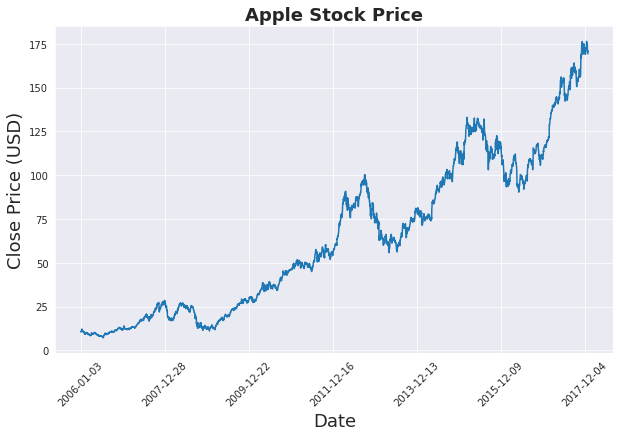

In [4]:
sns.set_style("darkgrid")
plt.figure(figsize = (10,6))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Apple Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

**Normalization**

Now, we normalize the price values using MinMaxScaler module:

In [5]:
from sklearn.preprocessing import MinMaxScaler

prices = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1,1))
prices['Close'] = scaler.fit_transform(prices['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**Data split to train and test sets**


In [6]:
#data split:

def data_split(stock_prices, seq_len, ratio = 0.2):
  """
  seq_len: is the length of each sequence. We use seq_len - 1 elements for 
    training data and the last element is the target.
    for exampld if seq_len = 20, then the shape of each sample is (19,1) 
    and the target is a scalar value! 

  ratio: indicates the portion of test set

  """
  # we generate all combination of sequential data with lenght seq_len
  raw_data = stock_prices.to_numpy()
  data = []
  for i in range( len(raw_data) - seq_len ):
    data.append( raw_data[i: i + seq_len] )

  data = np.array(data)

  test_set_size = int(np.round(ratio * data.shape[0]))
  train_test_size = data.shape[0] - test_set_size

  X_train = data[0:train_test_size, :-1, :]
  y_train = data[0:train_test_size, -1, :]

  X_test = data[train_test_size: , : -1, :]
  y_test = data[train_test_size:, -1, :]
  return [X_train, y_train, X_test, y_test]



In [7]:
X_train, y_train, X_test, y_test = data_split(prices, 20)

# let's see what is the size of the training set!
print('train size is ', X_train.shape)
print('test size is ', y_test.shape)

train size is  (2399, 19, 1)
test size is  (600, 1)


In [8]:
import torch
import torch.nn as nn


# Converting the data sets to tensors

X_train_tensor = torch.from_numpy(X_train).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
X_test_tensor = torch.from_numpy(X_test).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

**Neural Net (RNN):**

Now, we define our neural network. First, let's define our RRN:

In [178]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first= True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
    out, _ = self.rnn(x, (h0.detach()))
    out = self.fc(out[:, -1, :])

    return out 

In [179]:
input_size = 1 # feature dimension of the input 
hidden_size = 32 #
num_layers = 2
output_size = 1 # outpust dimension
num_epochs = 100
learning_rate = 0.005

model = RNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)


**Training Loop:**

In [180]:
num_epochs = 100
Loss = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(X_train_tensor)

    loss = criterion(y_train_pred, y_train_tensor)
    print("Epoch ", t, "MSE: ", loss.item())
    Loss[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3244336247444153
Epoch  1 MSE:  0.1477007269859314
Epoch  2 MSE:  0.11988873034715652
Epoch  3 MSE:  0.11774709820747375
Epoch  4 MSE:  0.06653168052434921
Epoch  5 MSE:  0.03778912127017975
Epoch  6 MSE:  0.03850635513663292
Epoch  7 MSE:  0.020395442843437195
Epoch  8 MSE:  0.006964698433876038
Epoch  9 MSE:  0.03319947049021721
Epoch  10 MSE:  0.025546450167894363
Epoch  11 MSE:  0.004250234924256802
Epoch  12 MSE:  0.003571038134396076
Epoch  13 MSE:  0.012663362547755241
Epoch  14 MSE:  0.015461361967027187
Epoch  15 MSE:  0.011577149853110313
Epoch  16 MSE:  0.007937619462609291
Epoch  17 MSE:  0.008605465292930603
Epoch  18 MSE:  0.010174908675253391
Epoch  19 MSE:  0.007572914473712444
Epoch  20 MSE:  0.002565253060311079
Epoch  21 MSE:  0.001063776551745832
Epoch  22 MSE:  0.004192006308585405
Epoch  23 MSE:  0.006736001465469599
Epoch  24 MSE:  0.005360091105103493
Epoch  25 MSE:  0.0028781183063983917
Epoch  26 MSE:  0.0025891552213579416
Epoch  27 MSE:  0.0

In [181]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_tensor.detach().numpy()))

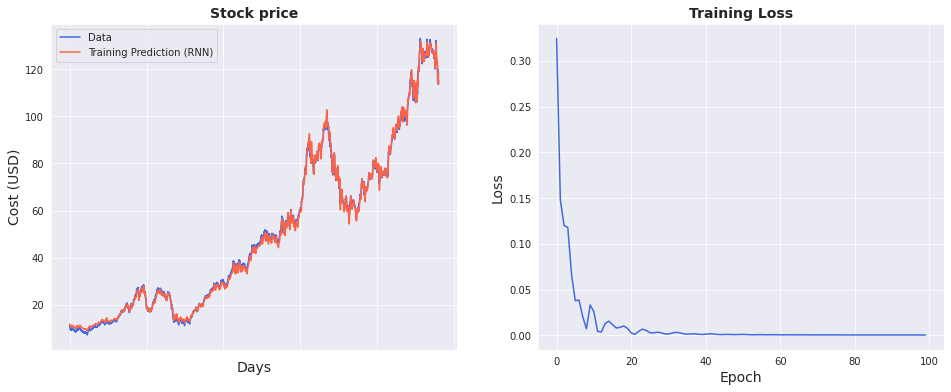

In [182]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (RNN)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=Loss, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

**Testing performance of the trained model:**

In [183]:
with torch.no_grad():
  y_test_pred_tensor = model(X_test_tensor)
  y_test_pred = scaler.inverse_transform(y_test_pred_tensor.numpy())
y_test = scaler.inverse_transform(y_test)

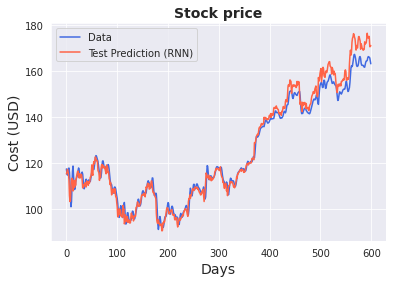

In [184]:
plt.plot(range(len(y_test)), y_test_pred, label="Data", color = 'royalblue')
plt.plot(range(len(y_test)), y_test, color='tomato', label="Test Prediction (RNN)")
plt.title('Stock price', size = 14, fontweight='bold')
plt.xlabel("Days", size = 14)
plt.ylabel("Cost (USD)", size = 14)
plt.legend()
plt.show()

**GRU:** 

To generate GRU, all we need to do is using ***`nn.GRU`*** instead of ***`nn.RNN`*** when we define the neural network. The network structure (in terms of code!) and the parameters are similar.


**LSTM:**

To generate LSTM network, in addition to using ***`nn.LSTM`***, we have to define cells. An example is given below:



In [9]:
#LSTM

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first= True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))


    out = self.fc(out[:, -1, :])

    return out


In [13]:
input_size = 1 # feature dimension of the input 
hidden_size = 32 #
num_layers = 2
output_size = 1 # outpust dimension
num_epochs = 100
learning_rate = 0.005

model = LSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [14]:
num_epochs = 100
Loss = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(X_train_tensor)

    loss = criterion(y_train_pred, y_train_tensor)
    print("Epoch ", t, "MSE: ", loss.item())
    Loss[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.29680243134498596
Epoch  1 MSE:  0.24547848105430603
Epoch  2 MSE:  0.2019406110048294
Epoch  3 MSE:  0.16607797145843506
Epoch  4 MSE:  0.14803481101989746
Epoch  5 MSE:  0.16231246292591095
Epoch  6 MSE:  0.1550697684288025
Epoch  7 MSE:  0.13494674861431122
Epoch  8 MSE:  0.12076102197170258
Epoch  9 MSE:  0.11327888071537018
Epoch  10 MSE:  0.10714491456747055
Epoch  11 MSE:  0.09744353592395782
Epoch  12 MSE:  0.08114581555128098
Epoch  13 MSE:  0.05917282775044441
Epoch  14 MSE:  0.04348008334636688
Epoch  15 MSE:  0.047579094767570496
Epoch  16 MSE:  0.029964076355099678
Epoch  17 MSE:  0.015084880404174328
Epoch  18 MSE:  0.02135654166340828
Epoch  19 MSE:  0.02291880175471306
Epoch  20 MSE:  0.014125468209385872
Epoch  21 MSE:  0.015443321317434311
Epoch  22 MSE:  0.021157333627343178
Epoch  23 MSE:  0.014906173571944237
Epoch  24 MSE:  0.008000661619007587
Epoch  25 MSE:  0.006924382410943508
Epoch  26 MSE:  0.007403980009257793
Epoch  27 MSE:  0.006283710245

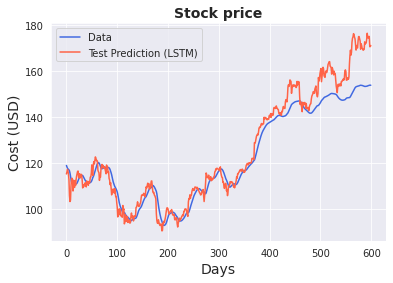

In [15]:
with torch.no_grad():
  y_test_pred_tensor = model(X_test_tensor)
  y_test_pred = scaler.inverse_transform(y_test_pred_tensor.numpy())
y_test = scaler.inverse_transform(y_test)


plt.plot(range(len(y_test)), y_test_pred, label="Data", color = 'royalblue')
plt.plot(range(len(y_test)), y_test, color='tomato', label="Test Prediction (LSTM)")
plt.title('Stock price', size = 14, fontweight='bold')
plt.xlabel("Days", size = 14)
plt.ylabel("Cost (USD)", size = 14)
plt.legend()
plt.show()